# Essay Keystrokes Project

This project is based on the Kaggle competition [Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality). The goal of the project is to use the data about each student's writing process while writing an SAT argumentative essay to predict the score that they receive on the essay. The goal of the project is to reduce the RMSE as much as possible. On Kaggle, the top entries have an RMSE of about .56 while median entries have an RMSE of about .58. For the competition, the test data set contains only 5 records; the full test data set is hosted on Kaggle. Because I want to work on GitHub and use this as an opportunity to develop my skills, I only use the training data and base my model performance on a train test split of the training data.

## 1. Importing the Data and Initial Review

### 1a. Imports and Shape

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('Data/train_logs.csv')

In [3]:
train_df.shape

(8405898, 11)

In [4]:
train_scores_df = pd.read_csv('Data/train_scores.csv')

In [5]:
train_scores_df.shape

(2471, 2)

While the train logs have over 8 million records, the train scores have only about 2.5k records. That means that there are around 3k train log records for each train score record. A major part of this project is going to consist of figuring out how to leverage as much value as possible from the high volume of train logs even though they will need to be aggregated to fit with the train score data.

### 1b. Train Log Data

In [6]:
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


Looking at the head of the dataframe shows the information that is available for each essay. In general, the data includes the time and position of every mouse click and key stroke. For each of these actions, the data includes the cursor position and word count. Knowing that this data needs to be aggregated to use it with the scores, some categories could include the total action time, the number of events, the final word count, and the time spent on each activity type.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


There are so many logs that the null values are not displaying. To limit the number of records, I create a dataframe that only has the logs for the first essay.

In [8]:
first_df = train_df[train_df['id'] == '001519c8']

In [9]:
first_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 0 to 2556
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2557 non-null   object
 1   event_id         2557 non-null   int64 
 2   down_time        2557 non-null   int64 
 3   up_time          2557 non-null   int64 
 4   action_time      2557 non-null   int64 
 5   activity         2557 non-null   object
 6   down_event       2557 non-null   object
 7   up_event         2557 non-null   object
 8   text_change      2557 non-null   object
 9   cursor_position  2557 non-null   int64 
 10  word_count       2557 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 239.7+ KB


The first essay has a mix of objects and integers. Fortunately, there are no null values. Lastly, I take a look at the total action time, final word count, and time spent on each activity for the first essay to finish my initial review of the data.

In [10]:
first_df['action_time'].sum()

297243

In [11]:
first_df.loc[first_df['event_id']==first_df['event_id'].max(), 'word_count']

2556    255
Name: word_count, dtype: int64

In [12]:
first_df['activity'].value_counts()

Input                                 2010
Remove/Cut                             417
Nonproduction                          120
Replace                                  7
Move From [287, 289] To [285, 287]       1
Move From [460, 461] To [465, 466]       1
Move From [284, 292] To [282, 290]       1
Name: activity, dtype: int64

The first essay has a total action time of 297243 milliseconds. It may be useful to convert that into seconds after aggregating to make the data more interpretable. The final word count is 255 words. The value count for the activity showed that that category is going to need some cleaning-- each time text gets moved, there is a unique label based on the position of the move. That will need to get addressed prior to aggregating the data.

Now that I have a sense of the logs, I take an initial look at the scores.

### 1c. Train Score Data

In [13]:
train_scores_df.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [14]:
train_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2471 non-null   object 
 1   score   2471 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.7+ KB


In [15]:
score_vals = train_scores_df['score'].value_counts()

In [16]:
score_counts = pd.DataFrame({'Score': score_vals.index, 'Number of Essays': score_vals.values})

In [17]:
score_counts

,Score,Number of Essays
0,4.0,501
1,3.5,486
2,4.5,402
3,3.0,336
4,2.5,201
5,5.0,179
6,5.5,128
7,2.0,92
8,1.5,69
9,6.0,37


In [18]:
score_counts.sort_values(by='Score',inplace=True)

In [19]:
score_counts.reset_index(inplace=True,drop=True)

In [20]:
score_counts

,Score,Number of Essays
0,0.5,5
1,1.0,35
2,1.5,69
3,2.0,92
4,2.5,201
5,3.0,336
6,3.5,486
7,4.0,501
8,4.5,402
9,5.0,179


In [21]:
custom_palette = ['#1768AC' if 3 <= score <= 4.5 else '#A2A7A5' for score in score_counts['Score']]

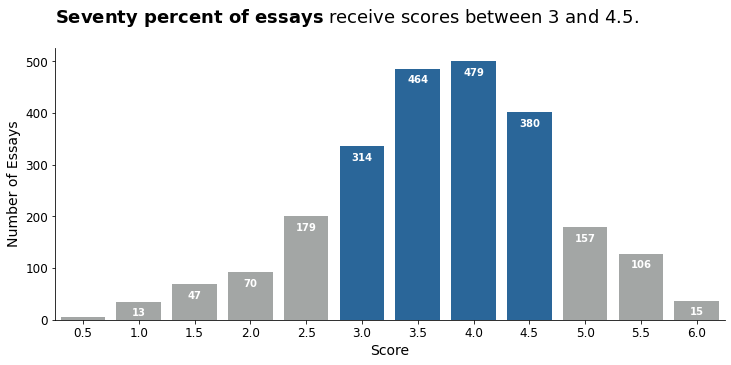

In [22]:
plt.figure(figsize=(12,5))
ax = sns.barplot(x='Score',y='Number of Essays',palette=custom_palette,data=score_counts)
title_text = r"$\bf{" 'Seventy \ percent \ of \ essays' "}$" + " receive scores between 3 and 4.5."

for p in ax.patches:
    height = (p.get_height() - 22)
    width = p.get_width()
    ax.annotate(f'{height:.0f}', (p.get_x() + width/2, height), ha='center', va='center', color='white', weight='bold')
    
plt.title(title_text, loc='left', pad=25, fontsize= 18)
plt.xlabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Number of Essays', fontsize=14)
plt.yticks(fontsize=12)
sns.despine()
plt.show();

## 2. Preparing for Modeling

start time for when the first input occurs 
use of quotation marks
and use of more advanced punctuation like semi colons and colons
use of periods-- 
Sentence length (word count divided by number of periods)

In [23]:
full_df = train_scores_df.copy()

### 2a. Total Action Time

In [24]:
action_time = train_df.groupby(by='id').sum()

In [25]:
action_time['id'] = action_time.index

In [26]:
action_time = action_time[['id', 'action_time']]

In [27]:
action_time.reset_index(drop=True,inplace=True)

In [28]:
action_time

,id,action_time
0,001519c8,297243
1,0022f953,275391
2,0042269b,421201
3,0059420b,189596
4,0075873a,313702
...,...,...
2466,ffb8c745,499670
2467,ffbef7e5,214221
2468,ffccd6fd,231580
2469,ffec5b38,289439


In [29]:
full_df = pd.merge(full_df, action_time, on='id')

In [30]:
full_df

,id,score,action_time
0,001519c8,3.5,297243
1,0022f953,3.5,275391
2,0042269b,6.0,421201
3,0059420b,2.0,189596
4,0075873a,4.0,313702
...,...,...,...
2466,ffb8c745,3.5,499670
2467,ffbef7e5,4.0,214221
2468,ffccd6fd,1.5,231580
2469,ffec5b38,5.0,289439


### 2b. Final Word Count

In [31]:
train_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [32]:
final_record_index = train_df.groupby('id')['word_count'].idxmax()

In [33]:
final_record_index

id
001519c8       2501
0022f953       4915
0042269b       9140
0059420b      10695
0075873a      13198
             ...   
ffb8c745    8391913
ffbef7e5    8395968
ffccd6fd    8397388
ffec5b38    8402273
fff05981    8405859
Name: word_count, Length: 2471, dtype: int64

In [34]:
word_count = train_df['word_count'].iloc[final_record_index]

In [35]:
word_count

2501       256
4915       323
9140       404
10695      206
13198      252
          ... 
8391913    461
8395968    438
8397388    201
8402273    413
8405859    241
Name: word_count, Length: 2471, dtype: int64

In [36]:
word_count_df = pd.DataFrame({'id':final_record_index.index,'word_count':word_count})

In [37]:
word_count_df.reset_index(drop=True,inplace=True)
word_count_df

,id,word_count
0,001519c8,256
1,0022f953,323
2,0042269b,404
3,0059420b,206
4,0075873a,252
...,...,...
2466,ffb8c745,461
2467,ffbef7e5,438
2468,ffccd6fd,201
2469,ffec5b38,413


In [38]:
full_df = pd.merge(full_df,word_count_df,on='id')
full_df

,id,score,action_time,word_count
0,001519c8,3.5,297243,256
1,0022f953,3.5,275391,323
2,0042269b,6.0,421201,404
3,0059420b,2.0,189596,206
4,0075873a,4.0,313702,252
...,...,...,...,...
2466,ffb8c745,3.5,499670,461
2467,ffbef7e5,4.0,214221,438
2468,ffccd6fd,1.5,231580,201
2469,ffec5b38,5.0,289439,413


### 2c. Event Count

In [39]:
event_count = train_df['event_id'].iloc[final_record_index]

In [40]:
event_count

2501       2502
4915       2359
9140       4130
10695      1549
13198      2496
           ... 
8391913    3283
8395968    2599
8397388    1415
8402273    3237
8405859    3581
Name: event_id, Length: 2471, dtype: int64

In [41]:
event_count_df = pd.DataFrame({'id':final_record_index.index,'event_count':event_count})
event_count_df.reset_index(drop=True,inplace=True)
event_count_df

,id,event_count
0,001519c8,2502
1,0022f953,2359
2,0042269b,4130
3,0059420b,1549
4,0075873a,2496
...,...,...
2466,ffb8c745,3283
2467,ffbef7e5,2599
2468,ffccd6fd,1415
2469,ffec5b38,3237


In [42]:
full_df = pd.merge(full_df,event_count_df,on='id')
full_df

,id,score,action_time,word_count,event_count
0,001519c8,3.5,297243,256,2502
1,0022f953,3.5,275391,323,2359
2,0042269b,6.0,421201,404,4130
3,0059420b,2.0,189596,206,1549
4,0075873a,4.0,313702,252,2496
...,...,...,...,...,...
2466,ffb8c745,3.5,499670,461,3283
2467,ffbef7e5,4.0,214221,438,2599
2468,ffccd6fd,1.5,231580,201,1415
2469,ffec5b38,5.0,289439,413,3237


### 2d. Event Count by Activity

In [43]:
train_df['activity'].value_counts()

Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [747, 960] To [1041, 1254]            1
Move From [114, 140] To [272, 298]              1
Move From [1766, 1968] To [1861, 2063]          1
Move From [999, 1000] To [1000, 1001]           1
Move From [51, 86] To [109, 144]                1
Move From [565, 743] To [669, 847]              1
Move From [2268, 2275] To [2247, 2254]          1
Move From [61, 136] To [0, 75]                  1
Move From [0, 1] To [590, 591]                  1
Move From [140, 272] To [299, 431]              1
Move From [218, 220] To [206, 208]              1
Move From [134, 169] To [122, 157]              1
Move From [923, 1077] To [340, 494]             1
Move From [1455, 1557] To [1323, 1425]          1


In [44]:
train_df.loc[train_df['activity'].str.contains('From',case=False), 'activity'] = 'Move'

In [45]:
train_df['activity'].value_counts()

Input            6726796
Remove/Cut        970158
Nonproduction     703851
Replace             4448
Paste                599
Move                  46
Name: activity, dtype: int64

In [46]:
activity_df = train_df.groupby(by='id')['activity'].value_counts().unstack(fill_value=0)

In [47]:
activity_df['id'] = activity_df.index

In [48]:
activity_df.reset_index(drop=True,inplace=True)

In [49]:
full_df = pd.merge(full_df,activity_df,on='id')
full_df

,id,score,action_time,word_count,event_count,Input,Move,Nonproduction,Paste,Remove/Cut,Replace
0,001519c8,3.5,297243,256,2502,2010,3,120,0,417,7
1,0022f953,3.5,275391,323,2359,1938,0,254,1,260,1
2,0042269b,6.0,421201,404,4130,3515,0,175,0,439,7
3,0059420b,2.0,189596,206,1549,1304,0,99,1,151,1
4,0075873a,4.0,313702,252,2496,1942,0,72,0,517,0
...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,461,3283,3588,0,189,0,960,2
2467,ffbef7e5,4.0,214221,438,2599,2395,0,148,0,60,1
2468,ffccd6fd,1.5,231580,201,1415,2849,0,126,0,88,0
2469,ffec5b38,5.0,289439,413,3237,2895,0,71,0,276,0


### 2e. Time of First Input

In [50]:
first_input_indices = train_df[train_df['activity'] == 'Input'].groupby('id').head(1).index

In [54]:
first_input_indices

Int64Index([      3,    2559,    5013,    9190,   10705,   13236,   15447,
              17212,   19565,   21150,
            ...
            8375005, 8378347, 8380231, 8383871, 8386632, 8388634, 8393373,
            8395976, 8399039, 8402281],
           dtype='int64', length=2471)

In [57]:
first_input_df = pd.DataFrame({'id':train_df['id'].iloc[first_input_indices],'time_of_first_input':train_df['down_time'].iloc[first_input_indices]})

In [58]:
first_input_df

,id,time_of_first_input
3,001519c8,106686
2559,0022f953,32706
5013,0042269b,21335
9190,0059420b,161494
10705,0075873a,94454
...,...,...
8388634,ffb8c745,28030
8393373,ffbef7e5,40574
8395976,ffccd6fd,39919
8399039,ffec5b38,27617


In [59]:
full_df = pd.merge(full_df,first_input_df, on='id')
full_df

,id,score,action_time,word_count,event_count,Input,Move,Nonproduction,Paste,Remove/Cut,Replace,time_of_first_input
0,001519c8,3.5,297243,256,2502,2010,3,120,0,417,7,106686
1,0022f953,3.5,275391,323,2359,1938,0,254,1,260,1,32706
2,0042269b,6.0,421201,404,4130,3515,0,175,0,439,7,21335
3,0059420b,2.0,189596,206,1549,1304,0,99,1,151,1,161494
4,0075873a,4.0,313702,252,2496,1942,0,72,0,517,0,94454
...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,461,3283,3588,0,189,0,960,2,28030
2467,ffbef7e5,4.0,214221,438,2599,2395,0,148,0,60,1,40574
2468,ffccd6fd,1.5,231580,201,1415,2849,0,126,0,88,0,39919
2469,ffec5b38,5.0,289439,413,3237,2895,0,71,0,276,0,27617


### 2f. Input Types

In [65]:
train_df.loc[(train_df['down_event'] == '.') | (train_df['down_event'] == ',') | 
             (train_df['down_event'] == ':') | (train_df['down_event'] == ';') |
             (train_df['down_event'] == '"') | (train_df['down_event'] == '/') |
             (train_df['down_event'] == '+') | (train_df['down_event'] == '(') |
             (train_df['down_event'] == '!') | (train_df['down_event'] == '?') |]

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
157,001519c8,158,172362,172451,89,Input,.,.,.,105,18
348,001519c8,349,305590,305703,113,Input,.,.,.,158,27
354,001519c8,355,315524,315721,197,Input,",",",",",",158,27
358,001519c8,359,319001,319124,123,Input,.,.,.,158,27
394,001519c8,395,389063,389177,114,Input,.,.,.,32,32
...,...,...,...,...,...,...,...,...,...,...,...
8405588,fff05981,3310,1904736,1904827,91,Input,",",",",",",1281,204
8405664,fff05981,3386,1927982,1928050,68,Input,",",",",",",1349,216
8405887,fff05981,3609,2057097,2057176,79,Input,",",",",",",1436,240
8405889,fff05981,3611,2058353,2058413,60,Input,.,.,.,1491,240


In [80]:
train_df.loc[train_df['text_change'].str.contains('q'), 'text_change'] = 'q'

In [87]:
train_df['text_change'].value_counts().head(25)

q           6136272
            1376829
NoChange     703851
.             67797
,             54797
\n            27977
'             13192
"              4659
-              4492
?              3507
;              2905
=              2288
/              1354
\              1100
:               813
(               733
[               725
)               660
!               639
>               177
]               157
.               137
$               112
*               108
&                77
Name: text_change, dtype: int64

In [88]:
text_change_df = train_df.groupby(by='id')['text_change'].value_counts().unstack(fill_value=0)

In [89]:
text_change_df = text_change_df[['.',',','"','?','!',':',';','-','#','@']]

In [91]:
text_change_df['id'] = text_change_df.index
text_change_df.reset_index(drop=True,inplace=True)
text_change_df

text_change,.,",","""",?,!,:,;,-,#,@,id
0,28,14,0,0,0,0,1,0,0,0,001519c8
1,18,24,6,3,0,0,0,6,0,0,0022f953
2,23,26,2,0,0,0,0,1,0,0,0042269b
3,13,3,0,0,0,0,0,0,0,0,0059420b
4,32,25,0,2,0,0,0,0,0,0,0075873a
...,...,...,...,...,...,...,...,...,...,...,...
2466,59,42,6,0,0,2,0,1,0,0,ffb8c745
2467,33,24,0,0,0,0,0,0,0,0,ffbef7e5
2468,6,3,0,0,0,0,0,0,0,0,ffccd6fd
2469,34,29,6,0,0,0,2,1,0,0,ffec5b38


In [92]:
full_df = pd.merge(full_df,text_change_df,on='id')
full_df

,id,score,action_time,word_count,event_count,Input,Move,Nonproduction,Paste,Remove/Cut,...,.,",","""",?,!,:,;,-,#,@
0,001519c8,3.5,297243,256,2502,2010,3,120,0,417,...,28,14,0,0,0,0,1,0,0,0
1,0022f953,3.5,275391,323,2359,1938,0,254,1,260,...,18,24,6,3,0,0,0,6,0,0
2,0042269b,6.0,421201,404,4130,3515,0,175,0,439,...,23,26,2,0,0,0,0,1,0,0
3,0059420b,2.0,189596,206,1549,1304,0,99,1,151,...,13,3,0,0,0,0,0,0,0,0
4,0075873a,4.0,313702,252,2496,1942,0,72,0,517,...,32,25,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,461,3283,3588,0,189,0,960,...,59,42,6,0,0,2,0,1,0,0
2467,ffbef7e5,4.0,214221,438,2599,2395,0,148,0,60,...,33,24,0,0,0,0,0,0,0,0
2468,ffccd6fd,1.5,231580,201,1415,2849,0,126,0,88,...,6,3,0,0,0,0,0,0,0,0
2469,ffec5b38,5.0,289439,413,3237,2895,0,71,0,276,...,34,29,6,0,0,0,2,1,0,0


### 2g. Sentence Length

In [93]:
full_df['sentence_length'] = full_df['word_count'] / full_df['.']

In [96]:
full_df

,id,score,action_time,word_count,event_count,Input,Move,Nonproduction,Paste,Remove/Cut,...,",","""",?,!,:,;,-,#,@,sentence_length
0,001519c8,3.5,297243,256,2502,2010,3,120,0,417,...,14,0,0,0,0,1,0,0,0,9.142857
1,0022f953,3.5,275391,323,2359,1938,0,254,1,260,...,24,6,3,0,0,0,6,0,0,17.944444
2,0042269b,6.0,421201,404,4130,3515,0,175,0,439,...,26,2,0,0,0,0,1,0,0,17.565217
3,0059420b,2.0,189596,206,1549,1304,0,99,1,151,...,3,0,0,0,0,0,0,0,0,15.846154
4,0075873a,4.0,313702,252,2496,1942,0,72,0,517,...,25,0,2,0,0,0,0,0,0,7.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,461,3283,3588,0,189,0,960,...,42,6,0,0,2,0,1,0,0,7.813559
2467,ffbef7e5,4.0,214221,438,2599,2395,0,148,0,60,...,24,0,0,0,0,0,0,0,0,13.272727
2468,ffccd6fd,1.5,231580,201,1415,2849,0,126,0,88,...,3,0,0,0,0,0,0,0,0,33.500000
2469,ffec5b38,5.0,289439,413,3237,2895,0,71,0,276,...,29,6,0,0,0,2,1,0,0,12.147059
